In [1]:
import json
import requests
import collections 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import statsmodels as sms
import statsmodels.stats.multitest as smt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Section 1: Data Wrangling

The dataset of interest was downloaded from Riot Game's API. The code I used to interact with the API can be found in 'Lolmatchdata.ipynb'. Initially, it had the format of a nested JSON file. With the JSON file loaded, I immediately turned it into a dataframe and checked its structure. We can see that as it stands, each row represents a game and the columns represent some general aspects of that game 

In [3]:
with open('much_lol_data.json', 'r') as file:
   data = json.load(file) 
df = pd.DataFrame(data)
print(df.shape) # The dataframe has 1274 rows, and 13 columns 
df.head() 

(1274, 13)


,gameCreation,gameDuration,gameId,gameMode,gameType,gameVersion,mapId,participantIdentities,participants,platformId,queueId,seasonId,teams
0,1547596951223,2045,2953655077,CLASSIC,MATCHED_GAME,9.1.257.7563,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T..."
1,1547535028615,973,2953405899,CLASSIC,MATCHED_GAME,9.1.257.7563,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T..."
2,1547532226325,2340,2953398465,CLASSIC,MATCHED_GAME,9.1.257.7563,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T..."
3,1547529414046,2005,2953370371,CLASSIC,MATCHED_GAME,9.1.257.7563,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ..."
4,1547518323960,1296,2953217441,CLASSIC,MATCHED_GAME,9.1.257.7563,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ..."


The columns that I care about here are those called 'gameMode' and 'participants'. League of Legends has a few game modes, but we are interested in the CLASSIC mode, which is the most popular and competitive mode. Extracting the columns and rows of interest was easy to do with Pandas.

In [3]:
df['gameMode'].unique() # There are four different modes

array(['CLASSIC', 'ARAM', 'GAMEMODEX', 'URF'], dtype=object)

In [4]:
# Extract the columns of interest
games = df[['participants','gameMode']]

# We only want games on the Summoner's Rift map (CLASSIC) 
classicgames = games[games['gameMode'] == 'CLASSIC']['participants']
classicgames.head()

0    [{'participantId': 1, 'teamId': 100, 'champion...
1    [{'participantId': 1, 'teamId': 100, 'champion...
2    [{'participantId': 1, 'teamId': 100, 'champion...
3    [{'participantId': 1, 'teamId': 100, 'champion...
4    [{'participantId': 1, 'teamId': 100, 'champion...
Name: participants, dtype: object

Below is an example of the stats and data from one game (row). There are five players on each of two teams, making a total of 10 players (10 'participantIds"). Each game info is essentially compiled into a list of 10 dictionaries, with one dictionary for each player. classicgames[1][0] is an example of the stats available from one player in a game.

In [9]:
print('There are', len(classicgames[0]), 'players in a game of LoL')

There are 10 players in a game of LoL


In [11]:
classicgames[1][0]

{'participantId': 1,
 'teamId': 100,
 'championId': 203,
 'spell1Id': 11,
 'spell2Id': 4,
 'stats': {'participantId': 1,
  'win': True,
  'item0': 1412,
  'item1': 2031,
  'item2': 3086,
  'item3': 3006,
  'item4': 2015,
  'item5': 1028,
  'item6': 3364,
  'kills': 6,
  'deaths': 1,
  'assists': 5,
  'largestKillingSpree': 6,
  'largestMultiKill': 1,
  'killingSprees': 1,
  'longestTimeSpentLiving': 815,
  'doubleKills': 0,
  'tripleKills': 0,
  'quadraKills': 0,
  'pentaKills': 0,
  'unrealKills': 0,
  'totalDamageDealt': 83847,
  'magicDamageDealt': 16109,
  'physicalDamageDealt': 63849,
  'trueDamageDealt': 3888,
  'largestCriticalStrike': 553,
  'totalDamageDealtToChampions': 11130,
  'magicDamageDealtToChampions': 2279,
  'physicalDamageDealtToChampions': 7753,
  'trueDamageDealtToChampions': 1098,
  'totalHeal': 7081,
  'totalUnitsHealed': 9,
  'damageSelfMitigated': 4945,
  'damageDealtToObjectives': 12970,
  'damageDealtToTurrets': 0,
  'visionScore': 14,
  'timeCCingOthers': 6

We are ready to create our dataframes from these dictionaries! I say dataframes because my approach was to create a dataframe specifically appropriate for exploratory and statistical data analysis, and then create another dataframe structured for optimal machine learning. The contents of both dataframes are the same: Each row still represents one game and both dataframes contain the same features I deemed relevant. 

The difference is the way the columns were organized and aggregated. For the EDA/Stats dataframe, the columns labels would be prefixed according to the WINNING TEAM ('WP' for individual player features, and 'Win' for aggregated team features, which will be discussed later), as well as the LOSING TEAM (prefixed with 'LP','Lose').

More will be mentioned the on structure of the Machine Learning dataframe, but it suffices to say for now that the column labels are instead prefixed as 'TeamA' and 'TeamB'. This allowed for an easy generation of the predictor variable column, which is vital for using models through sklearn.

Below, I created a function that takes in a game (row), and converts the list of dictionaries into a horizontal Pandas Series. I then used the apply method to apply this to all rows in classicgames.    

In [12]:
# Below is the list of columns headers that I want to keep
stats_keep_columns = ['participantId','win','item0','item1','item2','item3','item4','item5',
'item6','kills','deaths','assists','longestTimeSpentLiving','totalDamageDealtToChampions',
'magicDamageDealtToChampions', 'physicalDamageDealtToChampions','trueDamageDealtToChampions',
'damageDealtToTurrets','visionScore','timeCCingOthers','goldEarned','turretKills',
'perk0','perk1','perk2', 'perk3', 'perk4', 'perk5']

def create_row_for_stats(row):
    '''Unpacks each list of dictionaries, from each CLASSIC game, to create a pandas row.
    Each row is organized such that the features of the winning team are displayed to the 
    left.'''
      
    a_row = []   
    for players in row:
        stats_player = pd.DataFrame.from_dict(players['stats'], orient = 'index') #Turns the dict into a pandas row
        a_row.append(stats_player.T[stats_keep_columns]) # Transposes then extracts 
        champ_player = pd.DataFrame.from_dict(dict((list(players.items())[2],)), orient = 'index')
        a_row.append(champ_player.T) # Adds in the champion each player played
        the_row = pd.concat(a_row, axis = 1)
    
    # The code below organizes each row such that the stats on the first five players are always of the winners
    player_indexes = [index for index, col_name in enumerate(the_row) if col_name == 'participantId']
    if the_row.iloc[:,1].bool() == False:           
        losers = the_row.iloc[:,:player_indexes[5]]     
        the_row = pd.concat([the_row, losers], axis = 1)
        the_row = the_row.iloc[:,player_indexes[5]:]        
    the_row = the_row.drop('win',axis=1) # Drops the win columns
    return the_row 

    
all_games_for_stats = classicgames.apply(create_row_for_stats)
all_games_for_stats.head()

0      participantId item0 item1 item2 item3 item4 ...
1      participantId item0 item1 item2 item3 item4 ...
2      participantId item0 item1 item2 item3 item4 ...
3      participantId item0 item1 item2 item3 item4 ...
4      participantId item0 item1 item2 item3 item4 ...
Name: participants, dtype: object

The output of the previous cell does not look very glamourous, but if we look at each row individually, we can see each game now looks like a single-row dataframe, which can be concatenated as seen in upcoming cells. 

In [13]:
# Example of a game that occurred

all_games_for_stats[3]

,participantId,item0,item1,item2,item3,item4,item5,item6,kills,deaths,...,timeCCingOthers,goldEarned,turretKills,perk0,perk1,perk2,perk3,perk4,perk5,championId
0,6,3025,1055,3042,3003,1042,2422,3363,1,2,...,4,14035,2,8021,9111,9104,8014,8234,8236,18


As mentioned before, after concatenating the Pandas rows into one single dataframe, prefixes were added to the column headers to make clear to which player does the column refer.

In [14]:
# Concatenate all of the games into one dataframe

chunks = []
for chunk in all_games_for_stats:
    chunks.append(chunk)    
df_stats = pd.concat(chunks)
df_stats = df_stats.reset_index(drop=True)
df_stats.head()

,participantId,item0,item1,item2,item3,item4,item5,item6,kills,deaths,...,timeCCingOthers,goldEarned,turretKills,perk0,perk1,perk2,perk3,perk4,perk5,championId
0,1,1401,3111,3078,3053,1031,1011,3364,9,5,...,43,13320,0,8229,8226,8210,8236,8138,8105,1
1,1,1412,2031,3086,3006,2015,1028,3364,6,1,...,9,5408,0,8229,8226,8233,8236,8313,8347,101
2,1,3157,1026,3020,3916,3151,3116,3364,8,9,...,12,14651,0,8112,8143,8138,8105,8234,8236,141
3,6,3025,1055,3042,3003,1042,2422,3363,1,2,...,4,14035,2,8021,9111,9104,8014,8234,8236,18
4,6,3101,1004,2031,3098,3108,3117,3364,2,2,...,0,6483,0,8021,9111,9104,8014,8234,8236,145


In [15]:
# Rename the column headers according to winning and losing team

new_names = []

# Drop the 10 'paticipantid' columns
df_stats = df_stats.drop('participantId', axis=1) 

# Find the column index that signifies a new player 
player_indexes = [index for index, col_name in enumerate(df_stats) if col_name == 'item0']

for player in range(5):
    if player != 0:
        wp = df_stats.iloc[:,player_indexes[player]:player_indexes[player+1]].add_prefix('WP'+str(player+1)+'_')
    else:
        wp = df_stats.iloc[:,:player_indexes[player+1]].add_prefix('WP'+str(player+1)+'_')
    new_names.append(wp)
        
for player in range(5,10):
    if player != 9:
        lp = df_stats.iloc[:,player_indexes[player]:player_indexes[player+1]].add_prefix('LP'+str(player-4)+'_')
    else:
        lp = df_stats.iloc[:,player_indexes[player]:].add_prefix('LP'+str(player-4)+'_')
    new_names.append(lp)   
df_stats = pd.concat(new_names, axis=1).reset_index(drop=True)
df_stats.head()

,WP1_item0,WP1_item1,WP1_item2,WP1_item3,WP1_item4,WP1_item5,WP1_item6,WP1_kills,WP1_deaths,WP1_assists,...,LP5_timeCCingOthers,LP5_goldEarned,LP5_turretKills,LP5_perk0,LP5_perk1,LP5_perk2,LP5_perk3,LP5_perk4,LP5_perk5,LP5_championId
0,1401,3111,3078,3053,1031,1011,3364,9,5,14,...,43,13320,0,8229,8226,8210,8236,8138,8105,1
1,1412,2031,3086,3006,2015,1028,3364,6,1,5,...,9,5408,0,8229,8226,8233,8236,8313,8347,101
2,3157,1026,3020,3916,3151,3116,3364,8,9,17,...,12,14651,0,8112,8143,8138,8105,8234,8236,141
3,3025,1055,3042,3003,1042,2422,3363,1,2,2,...,4,14035,2,8021,9111,9104,8014,8234,8236,18
4,3101,1004,2031,3098,3108,3117,3364,2,2,10,...,0,6483,0,8021,9111,9104,8014,8234,8236,145


Another dataframe, 'team_stats', is made where each row still represents a game, but with the numerical stats aggregated based on the winning and losing team.  

In [16]:
# Create a new dataframe 'team_data', such that the numerical statistics of each player are aggregated by winning 
# and losing teams ('Win', 'Lose')

agg = ['kills', 'deaths', 'assists', 'physicalDamageDealtToChampions', 'magicDamageDealtToChampions',
       'trueDamageDealtToChampions','totalDamageDealtToChampions', 'timeCCingOthers', 'visionScore',
       'longestTimeSpentLiving', 'goldEarned', 'damageDealtToTurrets']

team_stats = pd.DataFrame()

for feature in agg: 
    team_stats['Win_'+ feature] = df_stats[[col for col in df_stats.columns if 'WP' in col 
                                            and feature in col]].sum(axis=1)
    team_stats['Lose_'+ feature] = df_stats[[col for col in df_stats.columns if 'LP' in col and 
                                             feature in col]].sum(axis=1)

# It will be very evident, very soon, that having the difference of damage dealt to turrets from winning 
# and losing team is important for statistical and machine learning purposes

team_stats['TurretDamageDiff'] = team_stats['Win_damageDealtToTurrets'] - team_stats['Lose_damageDealtToTurrets']
team_stats = team_stats.reset_index(drop=True)
team_stats.head()

,Win_kills,Lose_kills,Win_deaths,Lose_deaths,Win_assists,Lose_assists,Win_physicalDamageDealtToChampions,Lose_physicalDamageDealtToChampions,Win_magicDamageDealtToChampions,Lose_magicDamageDealtToChampions,...,Lose_timeCCingOthers,Win_visionScore,Lose_visionScore,Win_longestTimeSpentLiving,Lose_longestTimeSpentLiving,Win_goldEarned,Lose_goldEarned,Win_damageDealtToTurrets,Lose_damageDealtToTurrets,TurretDamageDiff
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,175.0,136.0,132.0,2881.0,3508.0,68627.0,57459.0,18539.0,10957.0,7582.0
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,63.0,42.0,54.0,1561.0,2556.0,29260.0,24569.0,3761.0,0.0,3761.0
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,134.0,127.0,134.0,2658.0,2397.0,80414.0,77352.0,27157.0,28543.0,-1386.0
3,15.0,35.0,36.0,15.0,13.0,60.0,40746.0,36048.0,30297.0,36046.0,...,94.0,94.0,141.0,2321.0,5477.0,57032.0,63015.0,22013.0,17478.0,4535.0
4,26.0,13.0,13.0,26.0,21.0,17.0,30744.0,16206.0,17770.0,19702.0,...,63.0,81.0,64.0,2684.0,2717.0,41397.0,32181.0,17840.0,3298.0,14542.0


### Section 2: Exploratory Data Analysis

Below are results of stats comparaisons between winning and losing team. For the most part, the stats look fairly even... 

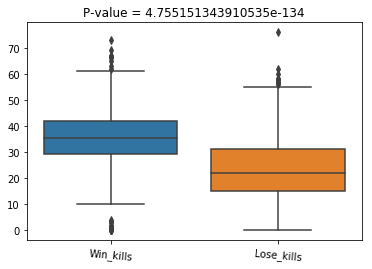

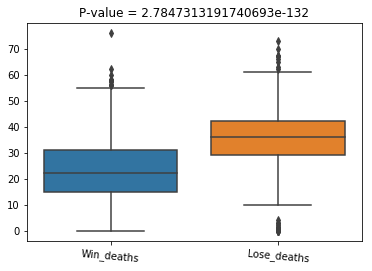

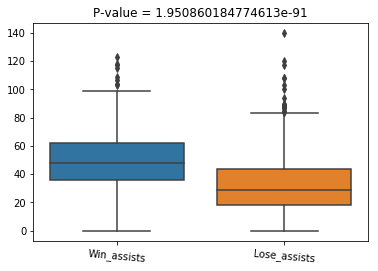

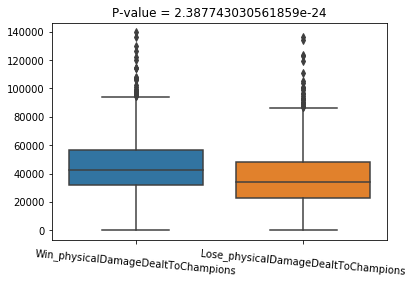

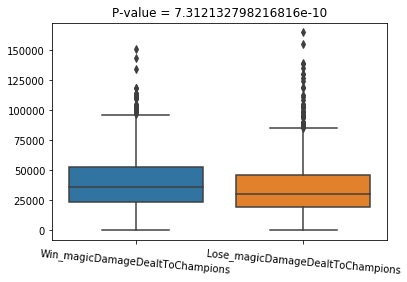

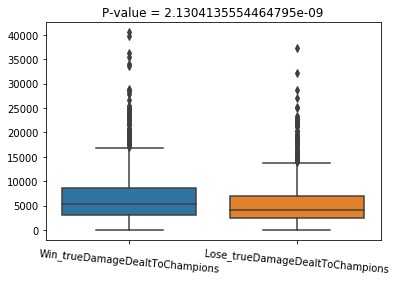

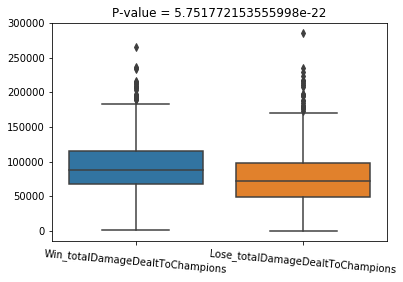

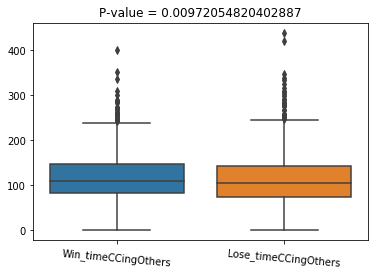

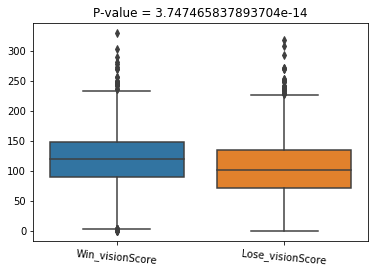

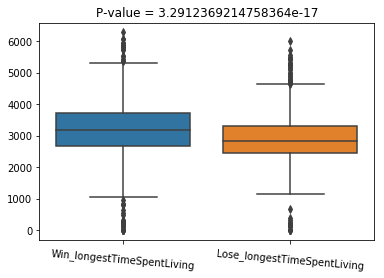

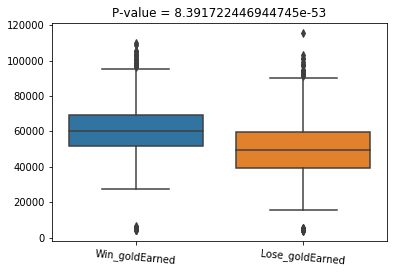

In [20]:
for feature in agg:
    if feature != 'damageDealtToTurrets':
        t_results = sp.stats.ttest_ind(team_stats['Win_'+feature], team_stats['Lose_'+feature])
        p_value = list(t_results)[1]
    
        plt.figure()
        sns.boxplot(data=team_stats[['Win_'+feature,'Lose_'+feature]]);
        plt.xticks(rotation=-5)
        plt.title('P-value = ' + str(p_value))

## Winning Team is ahead only by a bit...except...

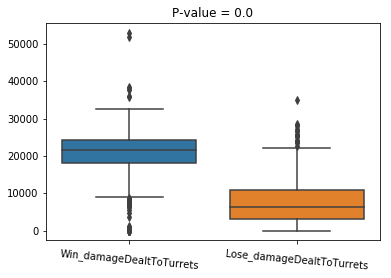

In [23]:
t_results = sp.stats.ttest_ind(team_stats['Win_damageDealtToTurrets'],team_stats['Lose_damageDealtToTurrets'])
p_value = list(t_results)[1]
    
plt.figure()
sns.boxplot(data=team_stats[['Win_damageDealtToTurrets','Lose_damageDealtToTurrets']]);
plt.xticks(rotation=-5)
plt.title('P-value = ' + str(p_value));

It appears that the winning team tend to do MUCH more Turret Damage, or at least much more compared to the losing team. This makes sense due to the fact that the goal of each game is to destroy the enemy nexus. 

To reiterate, the goal of a game of League of Legends is to destroy the enemy Nexus, or base for clarity. While enemy champions can certainly get in the way of one accomplishing this, another component that is objectively in the way are these enemy turrets. Each team has 11 turrets total, 3 in each of the three lanes, and 2 right near the turret. As a fundamental aspect of the game, to access the nexus, these turrets have to be eliminated.

![alt text](SummonersRift.png "Title")

The only way to get closer to the nexus is by destroying the turrets that are along the way. While getting kills, gold, vision, dragons etc... are absolutely helpful, they are secondary objectives, and technically not mandatory for getting closer to the nexus, while destroying turrets is indeed essential. There have been games wrapped up with kill scores as little as 3-5 and as large as 45-50, and sometimes, the team with the lower kill count would still win. Why? Because they destroyed the enemy nexus. While there are many different objectives in the game, getting kills, last-hitting minions, getting gold, what’s most imperative is how the team translates these features into increasing their advantage and getting closer to the enemy nexus. It would be safe to say that destroying these turrets is one of, if not the most, effective and reliable way to push a team’s advantage.   

I created a correlation heatmap that shows the **Pearson's correlation coefficient** to compare the winning team's stats to see if perhaps there are other specific stats that strongly correlate with turret damage. I also calculated the **Spearman's correlation coefficient** and their respective p-values for the same purpose. We can see that all features I’ve chosen to observe highly correlate with turret damage. League of Legends is very punishing game in the sense that one small advantage can really dictate the outcome of the game and be used to create more advantages. Getting a champion kill can lead to a gold advantage, which can lead to more kills, then more gold, and then more items which destroys turrets, thus creating more gold and more advantages.

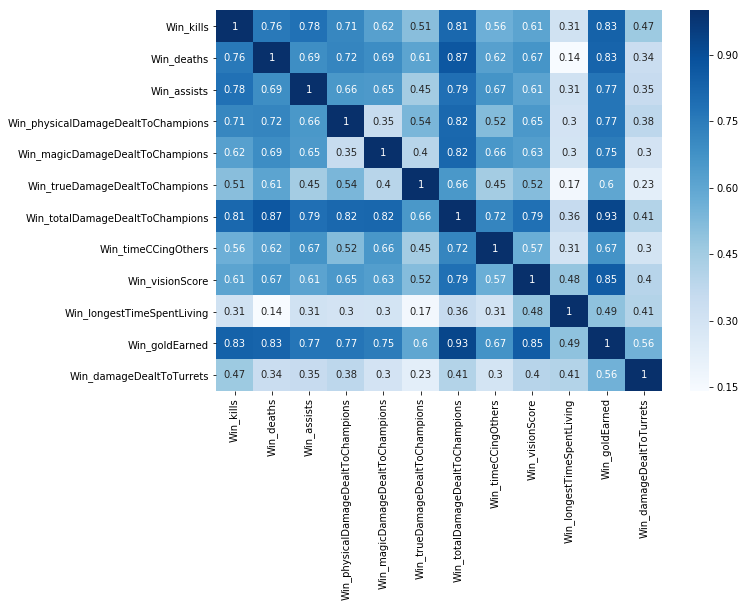

In [24]:
# Correlation heatmap (Pearson's)

winners = team_stats[[col for col in team_stats.columns if 'Win' in col]]

plt.figure(figsize=(10, 7))
sns.heatmap(winners.corr(), annot=True, cmap='Blues');              

In [25]:
# Getting Spearman correlation p-values

for feature in winners.columns:
    coef, pval = sp.stats.spearmanr(winners['Win_damageDealtToTurrets'], winners[feature])
    print(f"Spearman rank coefficient, p-value b/t Win_Turret Damage and {feature}: " + str(round(coef,3)) +
                                                                              ', ' + str(round(pval,3)))

Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_kills: 0.292, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_deaths: 0.249, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_assists: 0.203, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_physicalDamageDealtToChampions: 0.293, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_magicDamageDealtToChampions: 0.233, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_trueDamageDealtToChampions: 0.229, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_totalDamageDealtToChampions: 0.303, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_timeCCingOthers: 0.185, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_visionScore: 0.285, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_longestTimeSpentLiving: 0.217, 0.0
Spearman rank coefficient, p-value b/t Win_T

Thus far, it appears that the winning teams tend to have a much higher mean of Turret Damage compared to the losing team. The reason/intuition behind this is that destroying Turrets is in fact a MANDATORY objective, more so than killing enemy champions, getting a higher creep score, or any other objective in the game. 

This led me to my next question, does there tend to be a higher win rate among champions who ‘specialize’ in dealing damage to towers? I approached this question by forming **a two-sample t-test for comparing means**. One sample would include games (rows) that included a champion of interest, and the other sample would not include the champion at all. I would always utilize my whole dataset, meaning that whichever games that did not include my champion of interest would be included in the other sample.

The Riot API is formatted such that champion IDs, rune IDs, and item IDs are framed as integers. 

In [26]:
# Extracting the champID columns...The actual names of the champions are not shown.

champ_indexes = [col for col in df_stats.columns if 'championId' in col]  

champ_columns = df_stats[champ_indexes].reset_index(drop=True)
champ_columns.head()

,WP1_championId,WP2_championId,WP3_championId,WP4_championId,WP5_championId,LP1_championId,LP2_championId,LP3_championId,LP4_championId,LP5_championId
0,120,236,157,44,68,14,18,59,412,1
1,203,29,99,31,38,57,222,92,120,101
2,143,23,104,18,518,145,17,4,45,141
3,81,163,41,11,555,98,78,412,38,18
4,10,157,36,80,81,38,164,45,114,145


By accessing other Riot API endpoints, I was able to access the JSON files that associated their integers to their names.

In [28]:
url_champ = 'http://ddragon.leagueoflegends.com/cdn/8.24.1/data/en_US/champion.json'
champion_info = requests.get(url_champ).json()

url_rune = 'http://ddragon.leagueoflegends.com/cdn/8.24.1/data/en_US/runesReforged.json'
rune_info = requests.get(url_rune).json()

url_items = 'http://ddragon.leagueoflegends.com/cdn/8.24.1/data/en_US/item.json'
items_info = requests.get(url_items).json()

As an example, we can see below that the champion, Aatrox, is framed under the integer, 266. The key-value pairs we care about are such where keys = 'id' and 'name'.

In [29]:
champion_info['data']['Aatrox']

{'version': '8.24.1',
 'id': 'Aatrox',
 'key': '266',
 'name': 'Aatrox',
 'title': 'the Darkin Blade',
 'blurb': 'Once honored defenders of Shurima against the Void, Aatrox and his brethren would eventually become an even greater threat to Runeterra, and were defeated only by cunning mortal sorcery. But after centuries of imprisonment, Aatrox was the first to find...',
 'info': {'attack': 8, 'defense': 4, 'magic': 3, 'difficulty': 4},
 'image': {'full': 'Aatrox.png',
  'sprite': 'champion0.png',
  'group': 'champion',
  'x': 0,
  'y': 0,
  'w': 48,
  'h': 48},
 'tags': ['Fighter', 'Tank'],
 'partype': 'Blood Well',
 'stats': {'hp': 580,
  'hpperlevel': 80,
  'mp': 0,
  'mpperlevel': 0,
  'movespeed': 345,
  'armor': 33,
  'armorperlevel': 3.25,
  'spellblock': 32.1,
  'spellblockperlevel': 1.25,
  'attackrange': 175,
  'hpregen': 5,
  'hpregenperlevel': 0.25,
  'mpregen': 0,
  'mpregenperlevel': 0,
  'crit': 0,
  'critperlevel': 0,
  'attackdamage': 60,
  'attackdamageperlevel': 5,
  '

The key integers need to be converted to their respective names. In addition clarity's sake, it will establish the relevant columns as categorical. To do this conversion, I created three dictionaries,(for Champions, Runes, and Items), which contain the integer keys as keys, and their names as values (and Vice-Versa for robustness).  

In [34]:
# key_to_champ: Dictionary with the championID as keys and champion name as values 
# champ_to_key: Vice-versa

champ_list = list(champion_info['data'].keys())
champ_keys = []

for champ in champ_list:
    key = champion_info['data'][champ]['key']
    champ_keys.append(int(key))

champ_to_key = dict(zip(champ_list, champ_keys))
key_to_champ = dict(zip(champ_keys,champ_list))

print(list(key_to_champ.items())[:10]) #The first ten pairs of the dictionary

[(266, 'Aatrox'), (103, 'Ahri'), (84, 'Akali'), (12, 'Alistar'), (32, 'Amumu'), (34, 'Anivia'), (1, 'Annie'), (22, 'Ashe'), (136, 'AurelionSol'), (268, 'Azir')]


In [35]:
# key_to_rune: Dictionary with the RuneID as keys and rune name as values
# rune_to_key: Vice-versa

rune_to_key = {}
key_to_rune = {}

for rune_path in rune_info:
    for rune_line in rune_path['slots']:
        for rune in rune_line['runes']:
            rune_to_key[rune['key']] = rune['id']
            key_to_rune[rune['id']] = rune['key']
            
print(list(key_to_rune.items())[:10]) #The first ten pairs of the dictionary

[(8112, 'Electrocute'), (8124, 'Predator'), (8128, 'DarkHarvest'), (9923, 'HailOfBlades'), (8126, 'CheapShot'), (8139, 'TasteOfBlood'), (8143, 'SuddenImpact'), (8136, 'ZombieWard'), (8120, 'GhostPoro'), (8138, 'EyeballCollection')]


In [36]:
# key_to_rune: Dictionary with the RuneID as keys and rune name as values
# rune_to_key: Vice-versa

item_keys = list(items_info['data'].keys())
item_list = []
for key in item_keys:
    item = items_info['data'][key]['name']
    item_list.append(item)

item_keys = list(map(int, item_keys))

key_to_item = dict(zip(item_keys,item_list))
item_to_key = dict(zip(item_list,item_keys))

print(list(key_to_item.items())[:10]) #The first ten pairs of the dictionary

[(1001, 'Boots of Speed'), (1004, 'Faerie Charm'), (1006, 'Rejuvenation Bead'), (1011, "Giant's Belt"), (1026, 'Blasting Wand'), (1027, 'Sapphire Crystal'), (1028, 'Ruby Crystal'), (1029, 'Cloth Armor'), (1031, 'Chain Vest'), (1033, 'Null-Magic Mantle')]


I know from personal knowledge of the game that Tristana, a playable champion from League of Legends, has special abilities to specifically do more damage to turrets. To test if the champion does so at a statistically significant level, I instigated a **two-sample t-test for comparing means**. This is one instance where the column I previous created, TurretDamageDiff, will be very handy. 

After obtaining a p-value for Tristana, I created a function that could get a p-value from every existing champion. From here I would generate a list of p-values. Since at this point we are generating multiple null hypotheses and conducting multiple comparison tests, **false discovery rate controlling procedures**, more specifically, **Benjamini-Hochberg procedures** were applied to adjust our generated list of p-values in order to control the amount of Type I errors one may typically see in these multiple comparison tests   The p-values underneath our threshold would signify that their respective champions have a statistically significant impact on turret damage. We adjust our threshold ($\alpha$) to be 0.25.  

In [37]:
# First, generate a sample of games that includes Tristana
turrets = ['Win_damageDealtToTurrets','Lose_damageDealtToTurrets','TurretDamageDiff']

trist_index = []
trist_wins = 0
win_check = 5
for index, row in champ_columns.iterrows():
    for position, key in enumerate(row):
        # Could be changed to any other champion of interest, especially if we are interested in winrates.
        if key == champ_to_key['Tristana']:  
            trist_index.append(index)
            if position < win_check:
                trist_wins += 1 # We know the winners are represented by the first 5 columns
            break 

trist_games = team_stats[turrets].reset_index(drop=True).iloc[trist_index,:]
trist_games = trist_games[~np.all(trist_games == 0, axis=1)] # Removes games with missing values (0)
print("Tristana's winrate is",trist_wins/trist_games.shape[0])
trist_games.head()

Tristana's winrate is 0.4674329501915709


,Win_damageDealtToTurrets,Lose_damageDealtToTurrets,TurretDamageDiff
0,18539.0,10957.0,7582.0
2,27157.0,28543.0,-1386.0
3,22013.0,17478.0,4535.0
5,26606.0,9818.0,16788.0
8,27479.0,10277.0,17202.0


In [38]:
#Generate a sample of games that does NOT have Tristana

all_game_indexes = list(df_stats.reset_index(drop=True).index.values)
notrist_index = list(set(all_game_indexes) - set(trist_index))
notrist_games = team_stats[turrets].reset_index(drop=True).iloc[notrist_index,:]

notrist_games = notrist_games[~np.all(notrist_games == 0, axis=1)]
notrist_games.head()

,Win_damageDealtToTurrets,Lose_damageDealtToTurrets,TurretDamageDiff
1,3761.0,0.0,3761.0
4,17840.0,3298.0,14542.0
6,14133.0,15973.0,-1840.0
7,26834.0,3344.0,23490.0
9,16259.0,2130.0,14129.0


Text(0.5,1,'Does Tristana statistically impact turret damage?')

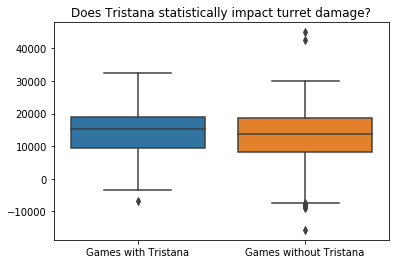

In [39]:
# Boxplot showing Turret Damage difference between winning/losing teams
# Left plot consists of games WITH Tristana, while right plot does NOT

sns.boxplot(data=[trist_games['TurretDamageDiff'], notrist_games['TurretDamageDiff']]);
plt.xticks([0,1,],['Games with Tristana','Games without Tristana']);
plt.title('Does Tristana statistically impact turret damage?')

In [40]:
#Prepping for t-test

trist = trist_games['TurretDamageDiff']
notrist = notrist_games['TurretDamageDiff']

mean_trist = np.mean(trist)
mean_notrist = np.mean(notrist)

mean_diff = mean_trist - mean_notrist

sp.stats.ttest_ind(trist, notrist)

Ttest_indResult(statistic=2.0329970682180223, pvalue=0.04226773095347995)

In [41]:
#pvalue = 0.042...Interesting, what about all other champions? Let's get a list of p-values for all champions!

#Generate a sample of games that Does have THE CHAMPION
turrets = ['Win_damageDealtToTurrets','Lose_damageDealtToTurrets','TurretDamageDiff']

champ_indexes = [col for col in df_stats.columns if 'championId' in col]  
champ_columns = df_stats[champ_indexes].reset_index(drop=True)

def champ_stats(name):
    '''Input a LoL champion to output the stats regarding turret damage
    win proportion, and p-values determining statistical significance of
    turret damage'''

    champ_index = []
    champ_wins = 0 # Initialize count
    win_check = 5 # We know the first five rows refer to the winning players 
    for index, row in champ_columns.iterrows():
        for position, key in enumerate(row):
            if key == champ_to_key[name]:
                champ_index.append(index)
                if position < win_check:
                    champ_wins += 1
                break 

    games_with = team_stats[turrets].reset_index(drop=True).iloc[champ_index,:]
    games_with = games_with[~np.all(games_with == 0, axis=1)] # Removes rows where all values equal 0 

    #Generate a random sample of games that does NOT have THE CHAMPION

    all_game_indexes = list(df_stats.reset_index(drop=True).index.values)
    nochamp_index = list(set(all_game_indexes) - set(champ_index))

    nogames_with = team_stats[turrets].reset_index(drop=True).iloc[nochamp_index,:]
    nogames_with = nogames_with[~np.all(nogames_with == 0, axis=1)]
    
    games = games_with['TurretDamageDiff']
    nogames = nogames_with['TurretDamageDiff']
    
    t_results = sp.stats.ttest_ind(games, nogames)
    p_value = list(t_results)[1]
    return (p_value)



In [42]:
turrets_pval = pd.DataFrame()
turrets_pval['Champion'] = champ_list
pvals = []
for champ in champ_list:
    pvals.append(champ_stats(champ))
turrets_pval['P-value'] = pvals
turrets_pval.head()

,Champion,P-value
0,Aatrox,0.173620
1,Ahri,0.006998
2,Akali,0.077597
3,Alistar,0.064499
4,Amumu,0.196314


In [43]:
# Collecting all the p-values and correcting them with Benjamini/Hochberg FDR 

corrected_pvals = smt.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

turrets_pval['Corrected P-value'] = corrected_pvals[1]

In [49]:
# Set threshold at 0.25 
turrets_pval[turrets_pval['Corrected P-value'] < 0.25]

,Champion,P-value,Corrected P-value
1,Ahri,0.006998,0.244437
36,Hecarim,0.003219,0.244437
41,Janna,0.005959,0.244437
70,MasterYi,0.008519,0.244437
120,Udyr,0.010328,0.244437
135,Yorick,0.010273,0.244437


These results thus indicate that when the following champions, Ahri, Hecarim, Janna, Master Yi, Udyr, and Yorick are present in the game, there is a statistically sigificant difference in turret damage between teams. The fact that Ahri and Janna made it to this list is rather surprising. They are magic damage dealers and their strengths are quite separate from dealing damage to turrets. However, the rest of the champions do have much more intuitive reasons behind making the list.

Hecarim, Master Yi, Udyr, and Yorick have their unique strengths, but one thing they all have in common is that they are all strong **split-pushers**. To understand what split-pushers are, it's first important to understand that Summoner's Rift, the name of the 'area' where the game takes place, is fairly large. In general, it takes about a solid 25 seconds to go from one corner of the map to the other. Also, League of Legends uses Fog of War mechanics, meaning unless you or anyone on your team is next to an enemy, enemies cannot be seen. Split-pushing is the act of going to a lane, typically the top or bottom lane (whichever is farthest from where most of the enemy team is located), and dealing damage to turrets on that lane, on your own. 

Here is a very common situation in League of Legends: A Fire Dragon is up at the Dragon Pit, which is on the bottom-right corner of the map. Whoever destroys the dragon gets a boost of attack damage for their whole team. All 5 members from Team A are at the pit, and only 4 members from Team B are at the pit. The remaining member from Team B is at the top lane, **split** from the rest of the team, **pushing** and dealing damage to turrets. Team B is obviously at a disadvantage in one sense, because numbers can have a strong influence on how team fights play out. While the 4 members from Team B are pursuing this high-risk high-reward strategy (risk: less members, reward: getting champion kills and a fire dragon). The split-pusher from Team B up top is getting guaranteed turret damage, which ultimately facilitates access to the enemy nexus. Trade-offs play a major theme in League of Legends, and gauging them and deciding whether to take action or not is simply part of the game.  

The most frequent qualities of a good split-pusher are: high movement speed, high attack speed, and decent tankiness (They absorb damage well). The four champions previously mentioned indeed have those characteristics.

### Section 3: Machine Learning

The next step is to prepare a dataframe for machine learning. This dataframe is merely different in terms of structure and organization, such that features are labeled according to Team A/B, instead of Winning/Losing Team, which facilitated doing certain statistical analysis. Another column was added, which contains the predictor variables for our model. A value of 1 means Team A won that match, whereas a value of 0 means Team B won that match. 

While Machine Learning is more popularly known for making predictions, we are also, if not more interested in, determining the strongest features that dictate win conditions. Implementing a **Logistic Regression model** would be one of the most effective ways to accomplish this, since it is easy to extract coefficient values for all features. 

In [54]:
# Prepping Dataframe for Logistic Regression

# The function below is essentially the same as the previous function (create_row_for_stats),
# except I took off the code that makes the first five players of the relevant team.

def create_row_for_ML(row):
    '''Unpacks each list of dictionaries, from each CLASSIC game, to create a pandas row.'''

    a_row = []   
    for players in row:
        stats_player = pd.DataFrame.from_dict(players['stats'], orient = 'index') #Turns the dict into a pandas row
        a_row.append(stats_player.T[stats_keep_columns]) #Transposes then extracts 
        champ_player = pd.DataFrame.from_dict(dict((list(players.items())[2],)), orient = 'index')
        a_row.append(champ_player.T) #Adds in the champion each player played
        the_row = pd.concat(a_row, axis = 1)

    return the_row 

    
all_games_for_ML = classicgames.apply(create_row_for_ML)
all_games_for_ML.head()

0      participantId   win item0 item1 item2 item3 ...
1      participantId   win item0 item1 item2 item3 ...
2      participantId   win item0 item1 item2 item3 ...
3      participantId    win item0 item1 item2 item3...
4      participantId    win item0 item1 item2 item3...
Name: participants, dtype: object

In [55]:
# Let Wins for Team A be represented by 1, and wins for Team B be represented by 0
chunks = []
for chunk in all_games_for_ML:
    if chunk.iloc[:,1].bool() == True:
        chunk['Team_win'] = 1
    else:
        chunk['Team_win'] = 0
    chunks.append(chunk)    
df_ML = pd.concat(chunks)
df_ML = df_ML.drop(['participantId','win'], axis=1)
df_ML.head()

,item0,item1,item2,item3,item4,item5,item6,kills,deaths,assists,...,goldEarned,turretKills,perk0,perk1,perk2,perk3,perk4,perk5,championId,Team_win
0,1401,3111,3078,3053,1031,1011,3364,9,5,14,...,13320,0,8229,8226,8210,8236,8138,8105,1,1
0,1412,2031,3086,3006,2015,1028,3364,6,1,5,...,5408,0,8229,8226,8233,8236,8313,8347,101,1
0,3157,1026,3020,3916,3151,3116,3364,8,9,17,...,14651,0,8112,8143,8138,8105,8234,8236,141,1
0,3748,3075,3047,3068,0,0,3363,4,2,12,...,8380,0,8112,8143,8136,8135,8275,8210,555,0
0,3020,3157,2033,3027,2055,0,3340,5,6,1,...,8340,2,8359,8304,8345,8347,8210,8226,81,0


In [56]:
# Renaming the column headers for clarity's sake

new_names = []
player_indexes = [index for index, col_name in enumerate(df_ML) if col_name == 'item0']
for player in range(5):
    if player != 0:
        wp = df_ML.iloc[:,player_indexes[player]:player_indexes[player+1]].add_prefix('TeamA_P'+str(player+1)+'_')
    else:
        wp = df_ML.iloc[:,:player_indexes[player+1]].add_prefix('TeamA_P'+str(player+1)+'_')
    new_names.append(wp)
        
for player in range(5,10):
    if player != 9:
        lp = df_ML.iloc[:,player_indexes[player]:player_indexes[player+1]].add_prefix('TeamB_P'+str(player-4)+'_')
    else:
        lp = df_ML.iloc[:,player_indexes[player]:len(list(df_ML))-1].add_prefix('TeamB_P'+str(player-4)+'_')
    new_names.append(lp)
new_names.append(df_ML.loc[:,'Team_win'])    
newdf_ML = pd.concat(new_names, axis=1)
newdf_ML.reset_index(drop=True).head()

,TeamA_P1_item0,TeamA_P1_item1,TeamA_P1_item2,TeamA_P1_item3,TeamA_P1_item4,TeamA_P1_item5,TeamA_P1_item6,TeamA_P1_kills,TeamA_P1_deaths,TeamA_P1_assists,...,TeamB_P5_goldEarned,TeamB_P5_turretKills,TeamB_P5_perk0,TeamB_P5_perk1,TeamB_P5_perk2,TeamB_P5_perk3,TeamB_P5_perk4,TeamB_P5_perk5,TeamB_P5_championId,Team_win
0,1401,3111,3078,3053,1031,1011,3364,9,5,14,...,13320,0,8229,8226,8210,8236,8138,8105,1,1
1,1412,2031,3086,3006,2015,1028,3364,6,1,5,...,5408,0,8229,8226,8233,8236,8313,8347,101,1
2,3157,1026,3020,3916,3151,3116,3364,8,9,17,...,14651,0,8112,8143,8138,8105,8234,8236,141,1
3,3748,3075,3047,3068,0,0,3363,4,2,12,...,8380,0,8112,8143,8136,8135,8275,8210,555,0
4,3020,3157,2033,3027,2055,0,3340,5,6,1,...,8340,2,8359,8304,8345,8347,8210,8226,81,0


In [57]:
# Converting the champ keys into champion name to give appropriate categorical name

championIDs = [col for col in newdf_ML.columns if 'championId' in col]
itemIDs = [col for col in newdf_ML.columns if 'item' in col]
runeIDs = [col for col in newdf_ML.columns if 'perk' in col]


for col in championIDs:
    newdf_ML[col] = newdf_ML[col].replace(key_to_champ)

for col in itemIDs:
    newdf_ML[col] = newdf_ML[col].replace(key_to_item)

for col in runeIDs:
    newdf_ML[col] = newdf_ML[col].replace(key_to_rune)

newdf_ML = newdf_ML.reset_index(drop=True)
newdf_ML.head()

,TeamA_P1_item0,TeamA_P1_item1,TeamA_P1_item2,TeamA_P1_item3,TeamA_P1_item4,TeamA_P1_item5,TeamA_P1_item6,TeamA_P1_kills,TeamA_P1_deaths,TeamA_P1_assists,...,TeamB_P5_goldEarned,TeamB_P5_turretKills,TeamB_P5_perk0,TeamB_P5_perk1,TeamB_P5_perk2,TeamB_P5_perk3,TeamB_P5_perk4,TeamB_P5_perk5,TeamB_P5_championId,Team_win
0,Enchantment: Cinderhulk,Mercury's Treads,Trinity Force,Sterak's Gage,Chain Vest,Giant's Belt,Oracle Lens,9,5,14,...,13320,0,ArcaneComet,ManaflowBand,Transcendence,GatheringStorm,EyeballCollection,RelentlessHunter,Annie,1
1,Enchantment: Warrior,Refillable Potion,Zeal,Berserker's Greaves,Kircheis Shard,Ruby Crystal,Oracle Lens,6,1,5,...,5408,0,ArcaneComet,ManaflowBand,AbsoluteFocus,GatheringStorm,PerfectTiming,CosmicInsight,Xerath,1
2,Zhonya's Hourglass,Blasting Wand,Sorcerer's Shoes,Oblivion Orb,Liandry's Torment,Rylai's Crystal Scepter,Oracle Lens,8,9,17,...,14651,0,Electrocute,SuddenImpact,EyeballCollection,RelentlessHunter,Celerity,GatheringStorm,Kayn,1
3,Titanic Hydra,Thornmail,Ninja Tabi,Sunfire Cape,0,0,Farsight Alteration,4,2,12,...,8380,0,Electrocute,SuddenImpact,ZombieWard,RavenousHunter,NimbusCloak,Transcendence,Pyke,0
4,Sorcerer's Shoes,Zhonya's Hourglass,Corrupting Potion,Rod of Ages,Control Ward,0,Warding Totem (Trinket),5,6,1,...,8340,2,Kleptomancy,MagicalFootwear,BiscuitDelivery,CosmicInsight,Transcendence,ManaflowBand,Ezreal,0


Just like what was done with the dataframe for statistical analysis, the dataframe for machine learning had its numerical columns aggregated team-wise. In addition, the categorical values were also aggregated team-wise by count. This includes items, runes, and technically champions, but since champions can only have counts of 0s or 1s, they can be thought of as having Pandas' get_dummies function applied to the columns pertaining to them. All champions in Ranked matches must be unique.

In [59]:
# TEAM DATA

agg = ['kills', 'deaths', 'assists', 'physicalDamageDealtToChampions', 'magicDamageDealtToChampions',
       'trueDamageDealtToChampions','totalDamageDealtToChampions', 'timeCCingOthers', 'visionScore',
       'longestTimeSpentLiving', 'goldEarned', 'damageDealtToTurrets']

team_ML = pd.DataFrame()

for feature in agg: 
    team_ML['TeamA_'+ feature] = newdf_ML[[col for col in newdf_ML.columns if 'TeamA' in col 
                                           and feature in col]].sum(axis=1)
    team_ML['TeamB_'+ feature] = newdf_ML[[col for col in newdf_ML.columns if 'TeamB' in col 
                                           and feature in col]].sum(axis=1)
team_ML['TurretDamageDiff'] = team_ML['TeamA_damageDealtToTurrets'] - team_ML['TeamB_damageDealtToTurrets']
team_ML = team_ML.reset_index(drop=True)
team_ML.head()

,TeamA_kills,TeamB_kills,TeamA_deaths,TeamB_deaths,TeamA_assists,TeamB_assists,TeamA_physicalDamageDealtToChampions,TeamB_physicalDamageDealtToChampions,TeamA_magicDamageDealtToChampions,TeamB_magicDamageDealtToChampions,...,TeamB_timeCCingOthers,TeamA_visionScore,TeamB_visionScore,TeamA_longestTimeSpentLiving,TeamB_longestTimeSpentLiving,TeamA_goldEarned,TeamB_goldEarned,TeamA_damageDealtToTurrets,TeamB_damageDealtToTurrets,TurretDamageDiff
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,175.0,136.0,132.0,2881.0,3508.0,68627.0,57459.0,18539.0,10957.0,7582.0
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,63.0,42.0,54.0,1561.0,2556.0,29260.0,24569.0,3761.0,0.0,3761.0
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,134.0,127.0,134.0,2658.0,2397.0,80414.0,77352.0,27157.0,28543.0,-1386.0
3,35.0,15.0,15.0,36.0,60.0,13.0,36048.0,40746.0,36046.0,30297.0,...,84.0,141.0,94.0,5477.0,2321.0,63015.0,57032.0,17478.0,22013.0,-4535.0
4,13.0,26.0,26.0,13.0,17.0,21.0,16206.0,30744.0,19702.0,17770.0,...,66.0,64.0,81.0,2717.0,2684.0,32181.0,41397.0,3298.0,17840.0,-14542.0


In [60]:
# Inputting item counts for each game

for item in item_list:
    team_ML['TeamA_'+ item] = 0
    team_ML['TeamB_'+ item] = 0

item_columns_TeamA = [col for col in newdf_ML.columns if 'item' in col and 'TeamA' in col]
item_columns_TeamB = [col for col in newdf_ML.columns if 'item' in col and 'TeamB' in col]
items_ML_TeamA = newdf_ML[item_columns_TeamA]
items_ML_TeamB = newdf_ML[item_columns_TeamB]

for game_index in range(0,team_ML.shape[0]):
    item_count_TeamA = collections.Counter((items_ML_TeamA.loc[game_index].tolist()))
    item_count_TeamB = collections.Counter((items_ML_TeamB.loc[game_index].tolist()))
    for item, count in list(item_count_TeamA.items()):
        if isinstance(item, str) == True:
            team_ML.loc[game_index,'TeamA_'+ item] = count
    for item, count in list(item_count_TeamB.items()):
        if isinstance(item, str) == True:
            team_ML.loc[game_index,'TeamB_'+ item] = count
team_ML.head()

,TeamA_kills,TeamB_kills,TeamA_deaths,TeamB_deaths,TeamA_assists,TeamB_assists,TeamA_physicalDamageDealtToChampions,TeamB_physicalDamageDealtToChampions,TeamA_magicDamageDealtToChampions,TeamB_magicDamageDealtToChampions,...,TeamA_Philosopher's Medallion,TeamB_Philosopher's Medallion,TeamA_Heart of Targon,TeamB_Heart of Targon,TeamA_Force of Nature,TeamB_Force of Nature,TeamA_Innervating Locket,TeamB_Innervating Locket,TeamA_Stat-Stick of Stoicism,TeamB_Stat-Stick of Stoicism
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,0,0,0,0,0,0,0,0,0,0
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,0,0,0,0,0,0,0,0,0,0
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,0,0,0,0,0,0,0,0,0,0
3,35.0,15.0,15.0,36.0,60.0,13.0,36048.0,40746.0,36046.0,30297.0,...,0,0,0,0,0,0,0,0,0,0
4,13.0,26.0,26.0,13.0,17.0,21.0,16206.0,30744.0,19702.0,17770.0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# Inputting rune counts for each game

rune_list = list(rune_to_key.keys())

for rune in rune_list:
    team_ML['TeamA_'+ rune] = 0
    team_ML['TeamB_'+ rune] = 0

rune_columns_TeamA = [col for col in newdf_ML.columns if 'perk' in col and 'TeamA' in col]
rune_columns_TeamB = [col for col in newdf_ML.columns if 'perk' in col and 'TeamB' in col]
rune_ML_TeamA = newdf_ML[rune_columns_TeamA]
rune_ML_TeamB = newdf_ML[rune_columns_TeamB]

for game_index in range(0,team_ML.shape[0]):
    rune_count_TeamA = collections.Counter(rune_ML_TeamA.loc[game_index].tolist())
    rune_count_TeamB = collections.Counter(rune_ML_TeamB.loc[game_index].tolist())
    for rune, count in list(rune_count_TeamA.items()):
        if isinstance(rune, str) == True:
            team_ML.loc[game_index,'TeamA_'+ rune] = count
    for rune, count in list(rune_count_TeamB.items()):
        if isinstance(rune, str) == True:
            team_ML.loc[game_index,'TeamB_'+ rune] = count
team_ML.head()

,TeamA_kills,TeamB_kills,TeamA_deaths,TeamB_deaths,TeamA_assists,TeamB_assists,TeamA_physicalDamageDealtToChampions,TeamB_physicalDamageDealtToChampions,TeamA_magicDamageDealtToChampions,TeamB_magicDamageDealtToChampions,...,TeamA_Celerity,TeamB_Celerity,TeamA_AbsoluteFocus,TeamB_AbsoluteFocus,TeamA_Scorch,TeamB_Scorch,TeamA_Waterwalking,TeamB_Waterwalking,TeamA_GatheringStorm,TeamB_GatheringStorm
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,0,1,2,1,1,0,0,0,1,3
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,0,1,2,1,0,1,1,1,1,1
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,0,3,1,1,2,1,0,1,1,3
3,35.0,15.0,15.0,36.0,60.0,13.0,36048.0,40746.0,36046.0,30297.0,...,1,1,0,0,0,1,0,0,1,1
4,13.0,26.0,26.0,13.0,17.0,21.0,16206.0,30744.0,19702.0,17770.0,...,1,0,1,1,1,1,1,0,2,1


In [62]:
# Inputting champ counts for each game

for champ in champ_list:
    team_ML['TeamA_'+ champ] = 0
    team_ML['TeamB_'+ champ] = 0

champ_columns_TeamA = [col for col in newdf_ML.columns if 'championId' in col and 'TeamA' in col]
champ_columns_TeamB = [col for col in newdf_ML.columns if 'championId' in col and 'TeamB' in col]
champ_ML_TeamA = newdf_ML[champ_columns_TeamA]
champ_ML_TeamB = newdf_ML[champ_columns_TeamB]


for game_index in range(0,team_ML.shape[0]):
    champ_count_TeamA = collections.Counter(champ_ML_TeamA.loc[game_index].tolist())
    champ_count_TeamB = collections.Counter(champ_ML_TeamB.loc[game_index].tolist())
    for champ, count in list(champ_count_TeamA.items()):
        if isinstance(champ, str) == True:
            team_ML.loc[game_index,'TeamA_'+ champ] = count
    for champ, count in list(rune_count_TeamB.items()):
        if isinstance(champ, str) == True:
            team_ML.loc[game_index,'TeamB_'+ champ] = count
team_ML.head()

,TeamA_kills,TeamB_kills,TeamA_deaths,TeamB_deaths,TeamA_assists,TeamB_assists,TeamA_physicalDamageDealtToChampions,TeamB_physicalDamageDealtToChampions,TeamA_magicDamageDealtToChampions,TeamB_magicDamageDealtToChampions,...,TeamA_Zed,TeamB_Zed,TeamA_Ziggs,TeamB_Ziggs,TeamA_Zilean,TeamB_Zilean,TeamA_Zoe,TeamB_Zoe,TeamA_Zyra,TeamB_Zyra
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,0,0,0,0,0,0,0,0,0,0
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,0,0,0,0,0,0,0,0,0,0
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,0,0,0,0,0,0,0,0,1,0
3,35.0,15.0,15.0,36.0,60.0,13.0,36048.0,40746.0,36046.0,30297.0,...,0,0,0,0,0,0,0,0,0,0
4,13.0,26.0,26.0,13.0,17.0,21.0,16206.0,30744.0,19702.0,17770.0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
team_ML['Team_win'] = newdf_ML['Team_win']
team_ML.head()

,TeamA_kills,TeamB_kills,TeamA_deaths,TeamB_deaths,TeamA_assists,TeamB_assists,TeamA_physicalDamageDealtToChampions,TeamB_physicalDamageDealtToChampions,TeamA_magicDamageDealtToChampions,TeamB_magicDamageDealtToChampions,...,TeamB_Zed,TeamA_Ziggs,TeamB_Ziggs,TeamA_Zilean,TeamB_Zilean,TeamA_Zoe,TeamB_Zoe,TeamA_Zyra,TeamB_Zyra,Team_win
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,0,0,0,0,0,0,0,0,0,1
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,0,0,0,0,0,0,0,0,0,1
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,0,0,0,0,0,0,0,1,0,1
3,35.0,15.0,15.0,36.0,60.0,13.0,36048.0,40746.0,36046.0,30297.0,...,0,0,0,0,0,0,0,0,0,0
4,13.0,26.0,26.0,13.0,17.0,21.0,16206.0,30744.0,19702.0,17770.0,...,0,0,0,0,0,0,0,0,0,0


We now have a fully numerical dataframe with all the features we care about, as well as a column of the variables we want our model to predict, 'Team_win', we are ready to begin creating our Logistic Regression model.

In [64]:
X = team_ML.drop('Team_win',axis = 1)
y = team_ML['Team_win']

In [105]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [106]:
# Begin tuning our first model

c_space = np.logspace(-10, 8, 20) # Covers a WIDE range of possible C values
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# This will be useful for creating our ROC curves 
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 6.951927961775605e-08, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.9809045226130654


The accuracy score looks very good (98!), and it looks like the model benefitted from implementing a **Ridge Regularization**. The low, optimal Logistic Regression Parameter, C, implies that the regularization strength is pretty high.

Since the features vary in numerical range, from 0 to 1, to 10,000 to 100,000, I was curious to see if standardizing all features would improve model accuracy. To test this, I created a machine learning pipeline that implements a standarization step, called **StandardScaler**, into the model.  

In [107]:
# Instantiate the pipeline steps
steps = [('scaler', StandardScaler()),
        ('logreg', LogisticRegression())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Set up parameter grid for GridSearchCV
c_space = np.logspace(-10, 8, 20) # Log scale covers wider magnitude of values
param_grid = {'logreg__C': c_space, 'logreg__penalty': ['l1', 'l2']} # May want to implement Lasso or Ridge regression

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv_scaled = GridSearchCV(pipeline, param_grid, cv=5)

# Fit it to the training data
logreg_cv_scaled.fit(X_train, y_train)

# This will be useful for creating our ROC curves 
y_pred_prob_scaled = logreg_cv_scaled.predict_proba(X_test)[:,1]

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv_scaled.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv_scaled.best_score_))

Tuned Logistic Regression Parameter: {'logreg__C': 0.2976351441631313, 'logreg__penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.9618090452261306


I extracted the top 10 and bottom 10 coefficients from my models, and generated side bar graphs to better visualize the impact that their corresponding features have. Since a victory for Team A and Team B are represented as values 1 and 0 respectively, it makes sense mathematically that the highest values indicate the biggest proponents for Team A's victory, and likewise for the lowest values on Team B's victory.  

In [95]:
# Extract the coefficients from our two models
coefs = list(logreg_cv.best_estimator_.coef_[0])
coefs_scaled = logreg_cv_scaled.best_estimator_.named_steps['logreg'].coef_.tolist()[0]

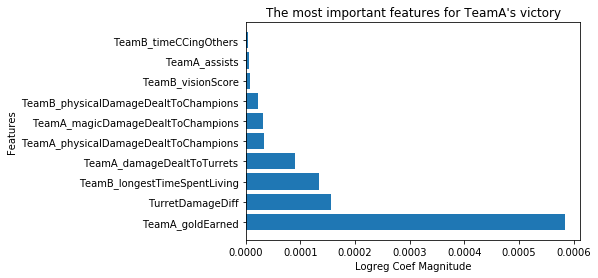

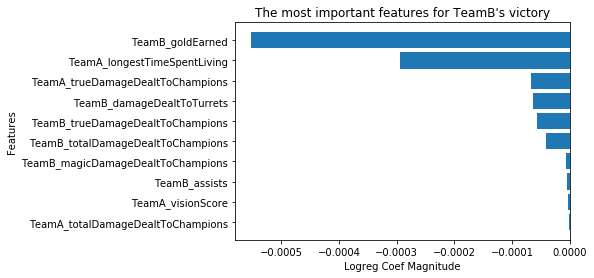

In [92]:
df_results = pd.DataFrame()
df_results['Features'] = X.columns.tolist()
df_results['Logreg_Coef'] = coefs
df_results = df_results[df_results['Logreg_Coef'] != 0].sort_values(by='Logreg_Coef', ascending = False)

teamA_strats = df_results.head(10)
teamB_strats = df_results.tail(10)

plt.figure()
plt.barh(teamA_strats['Features'],teamA_strats['Logreg_Coef'])
plt.title("The most important features for TeamA's victory")
plt.xlabel('Logreg Coef Magnitude')
plt.ylabel('Features');

plt.figure()
plt.barh(teamB_strats['Features'],teamB_strats['Logreg_Coef'])
plt.title("The most important features for TeamB's victory")
plt.xlabel('Logreg Coef Magnitude')
plt.ylabel('Features');

Seeing the same feature on both graphs is a rather helpful confirmation that the feature is indeed an important feature to predict victory. For example, from our first model we see that the amount of gold earned was the biggest indicator of both Team A and Team B's victory. This makes sense because simply put, generating gold allows one to buy items, which makes accomplishing all availble objectives in League of Legends easier. This was a given from the start, but I was more interested in other underlying details that can perhaps make this gold generation easier.     

Another interesting feature that seemed relevant in both teams' victory is the OTHER team's longest time spent living. My personal take in this is that the recently implemented Bounty System is the primary cause for this. Understanding this also requires some background knowledge of the game. As mentioned before, LoL is a punishing game in that gettting even a small advantage in the game can translate into dramatically pushing that advantage towards victory. In other words, the chances of making a comeback in the game tend to be rather unlikely for the losing team.  In order increase likelyhood of comebacks, Riot Games added a bounty system where players that are particularly far ahead would be WORTH MORE GOLD if destroyed by the other team. The higher a player's time avoiding death is a very strong indicator of how far that player is in the game. The data seems to imply that this bounty system generates so much gold for the the 'losing team' that it has become a top indicator for their victory! Comebacks have not only become more frequent, they dictate victories! Whether this system was intended to have that much influence is certainly up for debate.      

TurretDamageDiff made its way as the second most important feature for Team A's victory, since that feature was set to equal Team A's damage dealt to turrets minus Team B's damage dealt to turrets. The higher this value, the more damage Team A did than Team B. This further substantiates what we've concluded previously, that dealing damage to turrets is an important strategy to commit to. 

Other features common for both team's victory are all forms of damage damage dealt to champions, and, though lesser in impact, supplying vision for the team. Since these values are comparatively lower, it's too speculatory to say commiting to these strategies will help a team win.

I created two more side bars to show what the scaled Logistic Regression Model could tell us. Once again, TurretDamageDiff makes its way to the top, for predicting Team A's victory, but the rest of the features presented seem to be rather random (They don't overlap in both Team A and Team B's graphs.

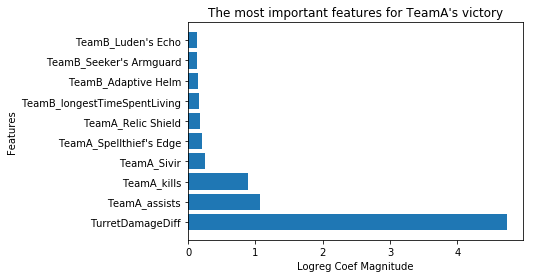

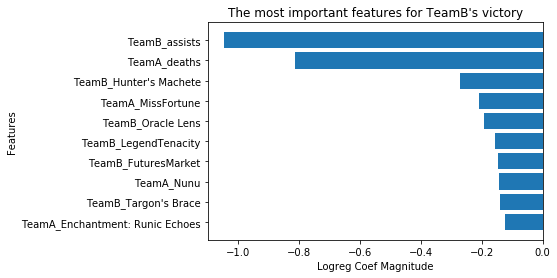

In [96]:
df_results = pd.DataFrame()
df_results['Features'] = X.columns.tolist()
df_results['Logreg_Coef'] = coefs_scaled
df_results = df_results[df_results['Logreg_Coef'] != 0].sort_values(by='Logreg_Coef', ascending = False)

teamA_strats = df_results.head(10)
teamB_strats = df_results.tail(10)

plt.figure()
plt.barh(teamA_strats['Features'],teamA_strats['Logreg_Coef'])
plt.title("The most important features for TeamA's victory")
plt.xlabel('Logreg Coef Magnitude')
plt.ylabel('Features');

plt.figure()
plt.barh(teamB_strats['Features'],teamB_strats['Logreg_Coef'])
plt.title("The most important features for TeamB's victory")
plt.xlabel('Logreg Coef Magnitude')
plt.ylabel('Features');

In a perfect world, I would create a model that successfully predicts which team would win based only on features that can be determined before the game even begins. Many of the features I used previously are those that happen in game. Having a model that can be used to help decide which players and runes would maximize one's chances of winning would undoubtedly be very appealing to every LoL player. With that in mind, I created yet another yet another dataframe, called pregame, to see how it would fair when fit into a Logistic Regression model. 

In [97]:
# Create a new dataframe, pregame, consisting only of features that can be determined before the game even begins.

pregame = pd.DataFrame()
pregame['Team_win'] = y

for rune in rune_list:
    pregame['TeamA_'+ rune] = team_ML['TeamA_'+ rune]
    pregame['TeamB_'+ rune] = team_ML['TeamB_'+ rune]

for champ in champ_list:
    pregame['TeamA_'+ champ] = team_ML['TeamA_'+ champ]
    pregame['TeamB_'+ champ] = team_ML['TeamB_'+ champ]

pregame.head()

,Team_win,TeamA_Electrocute,TeamB_Electrocute,TeamA_Predator,TeamB_Predator,TeamA_DarkHarvest,TeamB_DarkHarvest,TeamA_HailOfBlades,TeamB_HailOfBlades,TeamA_CheapShot,...,TeamA_Zed,TeamB_Zed,TeamA_Ziggs,TeamB_Ziggs,TeamA_Zilean,TeamB_Zilean,TeamA_Zoe,TeamB_Zoe,TeamA_Zyra,TeamB_Zyra
0,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
X_pregame = pregame.drop('Team_win',axis = 1)
y_pregame = pregame['Team_win']

In [111]:
c_space = np.logspace(-10, 8, 20)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Create train and test sets
X_train, X_test, y_train, y_test_pregame = train_test_split(X_pregame, y_pregame, test_size = 0.2, random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv_pregame = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the training data
logreg_cv_pregame.fit(X_train, y_train)

# This will be useful for creating our ROC curves 
y_pred_prob_pregame = logreg_cv_pregame.predict_proba(X_test)[:,1]

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv_pregame.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv_pregame.best_score_))

Tuned Logistic Regression Parameter: {'C': 0.03359818286283774, 'penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.5457286432160804


Unfortunately, the accuracy of 54.5% makes this model rather unreliable. Features matter! This lack of performance can be further visualized from a Receiver Operating Characteristic Curve (ROC Curve) for the model. ROC curves of the other models were also generated. We can see based on the area under the curve (AUC) not only the poor performance from the pregame model, and but the rather strong performance from the other models! The higher the AUC, the better the model can distinguish between the predictor variables. 

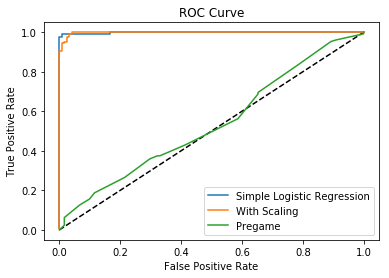

In [115]:
# Compute predicted probabilities: y_pred_prob
# y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
fpr_scaled, tpr_scaled, thresholds_scaled = roc_curve(y_test, y_pred_prob_scaled)
fpr_pregame, tpr_pregame, thresholds_pregame = roc_curve(y_test_pregame, y_pred_prob_pregame)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Simple Logistic Regression')
plt.plot(fpr_scaled, tpr_scaled, label='With Scaling')
plt.plot(fpr_pregame, tpr_pregame, label = 'Pregame')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

The data presented to us gives several meaningful conclusions on improving one's chance of winning a game of LoL: 
 - Maximizing turret damage is a worthy strategy to focus on
 - In particular, Hecarim, Master Yi, Udyr, and Yorick are strong contenders since the data implies they significantly impact turret damage difference between teams
 - Letting the other team get ahead in order to increase their bounties could potentially be an effective strategy

With this in mind, there is certainly more future work that can be done in order draw more conclusions and insights:

 - **Bring in more data.** This is always going to be an effective move. The reason it is so for this case is that the API was interacted with through using my personal account information. This means that all games used in the dataset fell into a fairly specific rank level. The rank levels that exist are Iron, Bronze, Silver, Gold, Platinum, Diamond, Master, Grandmaster, and Challenger. I fall into High Silver/Low Gold Rank, meaning all games used include players from similar ranks. In order to make the model more robust, more data from a wider distribution of ranks should be included.
 - **Implement more feature engineering.**  We saw from the side bar charts that Turret Damage difference was a significant feature that the model used to make its predictions. This can be done to a greater extent with essentially other features.